# Loan Data from Prosper Exploration
## by Yafen Zhang

## Summary

* ### Dataset Overview

    * This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, credit score, term, prosper score, listing category, employement status/duration, delinquent amount, debt to income ratio, net principle loss, recommendationsand, and many others. Most of the variables are numeric in nature, while the loan status and income range are objects and the listing creation date and first recorded credit line are datetimes.

* ### Investigation Overview

    * In this investigation, I wanted to look at the characteristics of loan borrowers that could be used to predict their borrower's apr that is correlated with lender's yield. The main focus was on: borrower's credit history, borrower's income, borrower's debt situation, and category of the loans.
    
* ### Data Wrangling
    * The debt to income ratio is also a little bit right-skewed with most values lower than 2 and outliers around 10 corresponding to someone with a large amount of debt. After a log transform, the distribution looks normal.
    * After log transform of monthly income, it's generally normally distributed winthin the range of about 50-100k. We could also observe outliers on both low and high ends.
    * The extreme stated monthly income data shows that most extreme values come from the low end, such as \\$0 income, while only a few come from the high end. The low end users are normally not employed or \\$0 in the income range.
    * Since the outliers are only about 1% of the whole data, I deleted the outliers found in the above distributions.

* ### Data Visualization
    * Scatter matrix between numeric variables show that the lender's yield has a strong positive correlation with the borrower's apr. For the borrower's apr, it has a weak negative correlation with credit score, a very weak positive correlation with debt to income ratio, and maybe a very weak negative correlation with the monthly income. The relationship between borrower's apr and total credit line in the past 7 years looks very scatter and has almost 0 covariance. But that total credit lines is positively correlated with monthly income.
    * Lender's yield and borrower's APR by Listing Category and Income Range show that there seems to be a negative correlation between borrower's apr/lender's yield and the income range, while no obvious relationship observed for the listing category. The highest borrower's apr/lender's yield are from cosmetic procedure and household exponses customers, and the lowest one is from personal loan.
    * Lender's yield by Listing Category and Income Range for selected borrower's APR range exhibit that for lower range of lender's yield the high income customers have higher variance, while for higher range of lender's yield the situation is the opposite - the low income borrowers have higher variance.

## Preliminary Wrangling

* This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, credit score, term, prosper score, listing category, employement status/duration, delinquent amount, debt to income ratio, net principle loss, recommendationsand, and many others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [2]:
df = pd.read_csv('prosperLoanData.csv',usecols=['ListingKey','ListingCreationDate',
                                                'Term','LoanStatus','BorrowerAPR','BorrowerRate',
                                               'LenderYield','EstimatedReturn','ProsperScore', 'ListingCategory (numeric)',
                                                'CreditScoreRangeLower','CreditScoreRangeUpper',
                                               'FirstRecordedCreditLine','TotalCreditLinespast7years',
                                               'AmountDelinquent','DebtToIncomeRatio','IncomeRange',
                                                'StatedMonthlyIncome','MonthlyLoanPayment','LP_NetPrincipalLoss'],
                                                 parse_dates=['ListingCreationDate','FirstRecordedCreditLine'])

In [3]:
df.head(5)

,ListingKey,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedReturn,ProsperScore,ListingCategory (numeric),CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,TotalCreditLinespast7years,AmountDelinquent,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,MonthlyLoanPayment,LP_NetPrincipalLoss
0,1021339766868145413AB3B,2007-08-26 19:09:29.263,36,Completed,0.16516,0.1580,0.1380,NaN,NaN,0,640.0,659.0,2001-10-11,12.0,472.0,0.17,"$25,000-49,999",3083.333333,330.43,0.0
1,10273602499503308B223C1,2014-02-27 08:28:07.900,36,Current,0.12016,0.0920,0.0820,0.05470,7.0,2,680.0,699.0,1996-03-18,29.0,0.0,0.18,"$50,000-74,999",6125.000000,318.93,0.0
2,0EE9337825851032864889A,2007-01-05 15:00:47.090,36,Completed,0.28269,0.2750,0.2400,NaN,NaN,0,480.0,499.0,2002-07-27,3.0,NaN,0.06,Not displayed,2083.333333,123.32,0.0
3,0EF5356002482715299901A,2012-10-22 11:02:35.010,36,Current,0.12528,0.0974,0.0874,0.06000,9.0,16,800.0,819.0,1983-02-28,29.0,10056.0,0.15,"$25,000-49,999",2875.000000,321.45,0.0
4,0F023589499656230C5E3E2,2013-09-14 18:38:39.097,36,Current,0.24614,0.2085,0.1985,0.09066,4.0,2,680.0,699.0,2004-02-20,49.0,0.0,0.26,"$100,000+",9583.333333,563.97,0.0


In [4]:
# rename the listingcategory column
df.rename(columns={'ListingCategory (numeric)':'ListingCategory'},inplace=True)
# replace the listing category numeric values with corresponding strings and convert to categorical
cat = {0:'Not Available',1:'Debt Consolidation',2:'Home Improvement',3:'Business',
           4:'Personal Loan',5:'Student Use',6:'Auto',7:'Other',8:'Baby&Adoption',
           9:'Boat',10:'Cosmetic Procedure',11:'Engagement Ring',12:'Green Loans',
          13:'Household Expenses',14:'Large Purchases',15:'Medical/Dental',16:'Motocycle',
          17:'RV',18:'Taxes',19:'Vacation',20:'Wedding Loans'}
listcat = []
for k in cat:
    df.ListingCategory[df.ListingCategory == k] = cat[k]
    listcat.append(cat[k])    
print(listcat)
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                            categories = listcat)
print(ordered_var)
df['ListingCategory'] = df['ListingCategory'].astype(ordered_var)
df.sample(5)

['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use', 'Auto', 'Other', 'Baby&Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motocycle', 'RV', 'Taxes', 'Vacation', 'Wedding Loans']
category


<ipython-input-4-32e7c9a824d1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ListingCategory[df.ListingCategory == k] = cat[k]


,ListingKey,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedReturn,ProsperScore,ListingCategory,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,TotalCreditLinespast7years,AmountDelinquent,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,MonthlyLoanPayment,LP_NetPrincipalLoss
92727,292735828852306868D3B6A,2013-07-09 16:26:02.900,60,Current,0.26128,0.2359,0.2259,0.1160,2.0,Household Expenses,700.0,719.0,1985-09-01,26.0,0.0,0.31,"$75,000-99,999",7416.666667,114.12,0.0
92726,27503531940601593704FE4,2011-12-01 11:25:01.910,36,Current,0.25494,0.2171,0.2071,0.1172,3.0,Home Improvement,720.0,739.0,2001-10-19,59.0,0.0,0.19,"$75,000-99,999",6541.666667,76.08,0.0
20665,C8133486684095014AC9F9E,2010-06-03 10:05:11.827,36,Completed,0.28574,0.2625,0.2525,0.1463,7.0,Business,680.0,699.0,1991-09-01,30.0,223.0,0.11,"$50,000-74,999",5833.333333,121.27,0.0
19637,4B0635323509020568DF629,2011-11-23 13:50:55.540,60,Current,0.09325,0.0911,0.0811,0.0736,10.0,Medical/Dental,780.0,799.0,1997-04-01,28.0,0.0,0.12,"$100,000+",8583.333333,416.24,0.0
48554,9AB435228546621644FA419,2011-08-11 19:24:29.133,36,Chargedoff,0.34621,0.3099,0.2999,0.1561,4.0,Home Improvement,640.0,659.0,2002-07-15,28.0,1516.0,0.19,"$100,000+",8583.333333,322.47,7500.0


In [5]:
# change dtype of income range to ordered category
income_cat = ['Not displayed','Not employed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                            categories = income_cat)
df['IncomeRange'] = df['IncomeRange'].astype(ordered_var)
df.sample(5)

,ListingKey,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedReturn,ProsperScore,ListingCategory,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,TotalCreditLinespast7years,AmountDelinquent,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,MonthlyLoanPayment,LP_NetPrincipalLoss
102035,9DF23531946556151338210,2011-11-26 14:17:29.443,36,Current,0.25494,0.2171,0.2071,0.11720,2.0,Debt Consolidation,700.0,719.0,1991-05-17,26.0,27136.0,0.39,"$25,000-49,999",3166.666667,570.61,0.0
6962,6EEC3595098741958ABAAD5,2013-11-12 00:58:43.840,36,Current,0.19144,0.1550,0.1450,0.08215,6.0,Debt Consolidation,680.0,699.0,2007-11-10,9.0,0.0,0.21,"$50,000-74,999",5416.666667,244.37,0.0
113516,F6B03564108853156B57900,2012-12-06 15:49:30.183,36,Current,0.35797,0.3177,0.3077,0.11740,6.0,Debt Consolidation,640.0,659.0,1989-06-12,6.0,0.0,0.07,"$25,000-49,999",2666.666667,173.71,0.0
99729,6AFC356063461126913FC16,2012-10-19 12:29:18.360,36,Current,0.13697,0.1089,0.0989,0.06570,7.0,Business,720.0,739.0,1998-09-23,43.0,0.0,0.17,"$100,000+",8500.000000,98.06,0.0
78091,85F93565691345489EE99A7,2012-12-17 12:12:54.573,36,Current,0.20462,0.1679,0.1579,0.08880,9.0,Medical/Dental,720.0,739.0,1995-09-01,16.0,0.0,0.18,"$75,000-99,999",8000.000000,394.59,0.0


In [6]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ListingKey                  113937 non-null  object        
 1   ListingCreationDate         113937 non-null  datetime64[ns]
 2   Term                        113937 non-null  int64         
 3   LoanStatus                  113937 non-null  object        
 4   BorrowerAPR                 113912 non-null  float64       
 5   BorrowerRate                113937 non-null  float64       
 6   LenderYield                 113937 non-null  float64       
 7   EstimatedReturn             84853 non-null   float64       
 8   ProsperScore                84853 non-null   float64       
 9   ListingCategory             113937 non-null  category      
 10  CreditScoreRangeLower       113346 non-null  float64       
 11  CreditScoreRangeUpper       113346 non-

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedReturn,ProsperScore,CreditScoreRangeLower,CreditScoreRangeUpper,TotalCreditLinespast7years,AmountDelinquent,DebtToIncomeRatio,StatedMonthlyIncome,MonthlyLoanPayment,LP_NetPrincipalLoss
count,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,113346.000000,113346.000000,113240.000000,106315.000000,105383.000000,1.139370e+05,113937.000000,113937.000000
mean,40.830248,0.218828,0.192764,0.182701,0.096068,5.950067,685.567731,704.567731,26.754539,984.507059,0.275947,5.608026e+03,272.475783,681.420499
std,10.436212,0.080364,0.074818,0.074516,0.030403,2.376501,66.458275,66.458275,13.637871,7158.270157,0.551759,7.478497e+03,192.697812,2357.167068
min,12.000000,0.006530,0.000000,-0.010000,-0.182700,1.000000,0.000000,19.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000,-954.550000
25%,36.000000,0.156290,0.134000,0.124200,0.074080,4.000000,660.000000,679.000000,17.000000,0.000000,0.140000,3.200333e+03,131.620000,0.000000
50%,36.000000,0.209760,0.184000,0.173000,0.091700,6.000000,680.000000,699.000000,25.000000,0.000000,0.220000,4.666667e+03,217.740000,0.000000
75%,36.000000,0.283810,0.250000,0.240000,0.116600,8.000000,720.000000,739.000000,35.000000,0.000000,0.320000,6.825000e+03,371.580000,0.000000
max,60.000000,0.512290,0.497500,0.492500,0.283700,11.000000,880.000000,899.000000,136.000000,463881.000000,10.010000,1.750003e+06,2251.510000,25000.000000


In [7]:
print(df.IncomeRange.value_counts())

$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64


### What is the structure of your dataset?

* There are 113937 loans in the resultant dataframe with 19 features. Most of the variables are numeric in nature, while the loan status and income range are objects and the listing creation date and first recorded credit line are datetimes.

### What is/are the main feature(s) of interest in your dataset?

* Information about the loan: e.g. interest rate, monthly payment, terms, estimated return
* Information about borrower: e.g. credit history, income, debt, 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

* I would expect that the lender yield is related to the borrower's interest rate/apr, the delinquent amount by borrower, and the uncollected pricipal after any recoveries. 
* The borrower's interest rate/apr or the customer risk score could be dependent on the borrowers credit history, borrower's income, and debt to income ratio. It may also relate to listing category which determines how much the borrower need for the loan.

## Univariate Exploration

* I am planning to start from investigating lender yield and borrower's interest rate/apr

In [8]:
# start from standard plot
def hist_col(df,column,binsize,label,start=0):
    bins = np.arange(start,df[column].max()+binsize,binsize)
    plt.figure(figsize=(10,6))
    plt.hist(data=df,x=column,bins=bins)
    plt.xlabel(label,size=12)
    plt.title('Distribution of '+label,size=15);

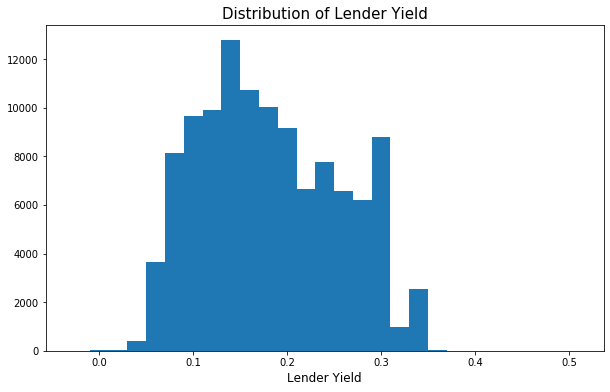

In [9]:
# plot lender yield distribution
hist_col(df,'LenderYield',0.02,'Lender Yield',df.LenderYield.min()-0.02)

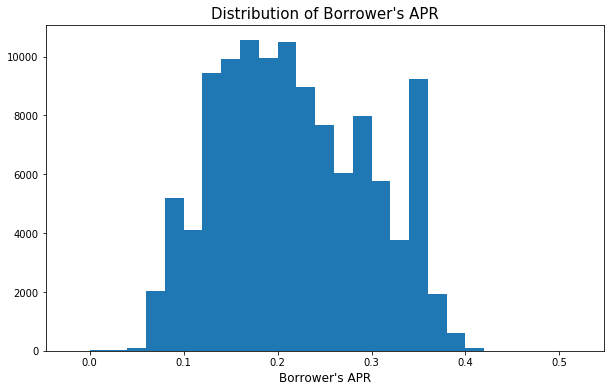

In [10]:
# plot borrower apr distribution
hist_col(df,'BorrowerAPR',0.02,"Borrower's APR",-0.02)

* The above two distributions look pretty normal, so no need to do further transformation. 
* Next, I would like to explore 'CreditScoreRangeLower/Higher', total credit lines, debt to income ratio, income range, monthly income, listing category 

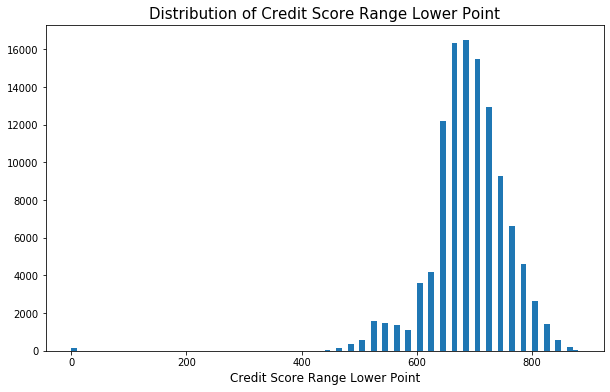

In [11]:
# plot distribution of Credit Score Range Lower point
hist_col(df,'CreditScoreRangeLower',10,'Credit Score Range Lower Point')

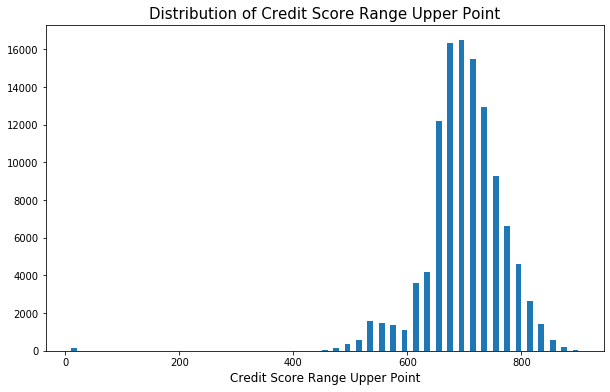

In [12]:
# plot distribution of Credit Score Range Upper point
hist_col(df,'CreditScoreRangeUpper',10,'Credit Score Range Upper Point', 10)

In [13]:
# only focusing on lower range point and find out the outliers
low_credit = (df.CreditScoreRangeLower < 400)
print(df[low_credit])

                     ListingKey     ListingCreationDate  Term  LoanStatus  \
794     00EF338150577356881AD6B 2007-02-11 13:40:55.490    36   Completed   
912     7A41337257909407897EB67 2006-11-14 08:23:08.430    36   Defaulted   
1685    403F33816853903261A0142 2007-02-06 15:50:46.723    36  Chargedoff   
4290    4B4C33658186085093BB6B4 2006-04-23 14:19:41.030    36  Chargedoff   
4371    985433663733409747DA533 2006-08-14 11:45:59.710    36   Defaulted   
...                         ...                     ...   ...         ...   
109855  FE063379142663462D83FD4 2007-01-17 13:07:35.540    36   Completed   
110290  7AB333803121117292D39C0 2007-02-10 21:22:12.553    36  Chargedoff   
111624  B4F6337744905877323E37A 2007-01-07 20:33:39.027    36   Defaulted   
113714  CD0F3365987359969F50347 2006-08-27 15:26:07.623    36  Chargedoff   
113848  FFF0338012502972731B2C1 2007-02-07 15:04:40.563    36   Completed   

        BorrowerAPR  BorrowerRate  LenderYield  EstimatedReturn  ProsperSco

* The Credit Score range at lower and upper point have similar distribution, so will only use one for further investigation on relationship with borrower's apr. It can be found that most credit scores are distributed in teh range of 400-900 except the outlier around 0 for both the lower and upper point
* After filter out the low credit users, we could observe that most of them have weird other values, like not displayed for the income range, no prosper score, low credit upper score range, and high net principal loss.

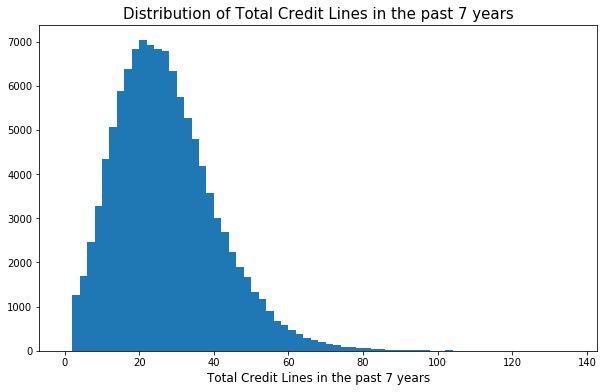

In [14]:
# plot distribution of total credit lines
hist_col(df,'TotalCreditLinespast7years',2,'Total Credit Lines in the past 7 years')

In [15]:
# log transform of the total credit lines distribution
def log_hist(df,column,log_binsize,label,start=0,num=5):
    bins = 10**np.arange(start,np.log10(df[column].max())+log_binsize,log_binsize)
    plt.figure(figsize=(10,6))
    plt.hist(data=df,x=column,bins=bins)
    plt.xscale('log')
    plt.xticks(10**np.linspace(start,np.log10(df[column].max())+log_binsize,num),np.round(10**np.linspace(start,np.log10(df[column].max())+log_binsize,num),1))
    plt.xlabel(label,size=12)
    plt.title('Distribution of '+label+' in Log',size=15);

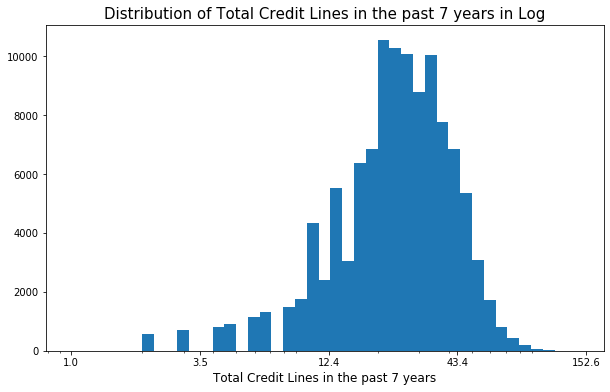

In [16]:
log_hist(df,'TotalCreditLinespast7years',0.05,'Total Credit Lines in the past 7 years')

* This number of credit lines in the past 7 years has a right skewed disbtribution, so I did a log transform to see how it changes. After log transform, the distribution looks more like normal distribution.

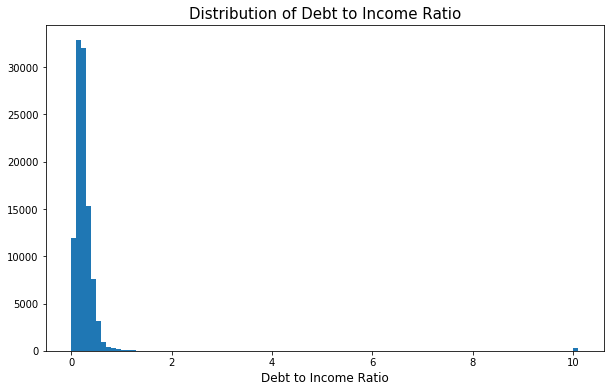

In [17]:
# plot the distribution of debt to income ratio
hist_col(df,'DebtToIncomeRatio',0.1,'Debt to Income Ratio')

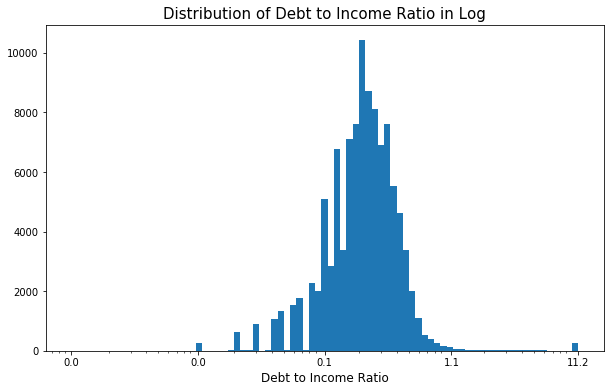

In [18]:
# log transform of debt to income ratio hist
log_hist(df,'DebtToIncomeRatio',0.05,'Debt to Income Ratio',-3)

In [19]:
# find out the outliers of debt to income ratio
high_debt = (df.DebtToIncomeRatio > 2)
print(df[high_debt])

                     ListingKey     ListingCreationDate  Term LoanStatus  \
22      101735700321773921526BF 2013-01-30 09:36:13.783    36    Current   
226     2EA63382419173023274969 2007-02-28 10:45:44.153    36  Completed   
576     3C18338635952151669AA4C 2007-04-16 17:44:06.780    36  Completed   
626     45C73538911628429AAB1CD 2012-02-20 16:08:45.633    36    Current   
1242    029C3391969521662B80577 2007-06-03 20:32:32.783    36  Completed   
...                         ...                     ...   ...        ...   
113258  F0903556207847780991044 2012-08-21 13:57:58.080    60  Defaulted   
113367  F3693583883111490E56B31 2013-07-03 07:07:34.657    36  Completed   
113387  DF323501487653892C93A36 2010-11-22 17:23:22.623    36  Completed   
113407  F3703411198534084FE3FAC 2008-01-31 10:27:02.483    36  Completed   
113626  DFB433665897044581828F7 2006-08-16 01:58:39.087    36  Completed   

        BorrowerAPR  BorrowerRate  LenderYield  EstimatedReturn  ProsperScore  \
22    

* The debt to income ratio is also a little bit right-skewed with most data smaller than 2 and outliers around 10 corresponding to someone with a large amount of debt. After a log transform, the distribution looks normal.
* With over 2 debt to income ratio, the users most likely have low incoem and high total credit lines.

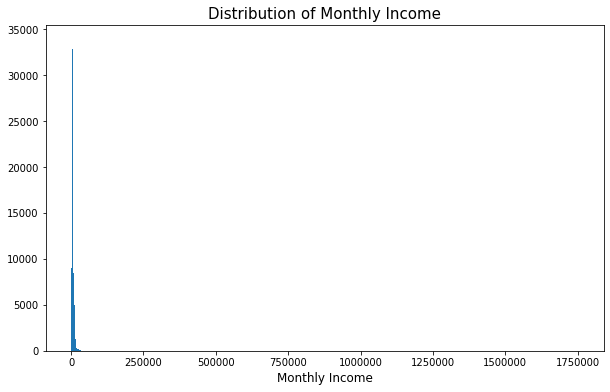

In [20]:
# plot hist of monthly income
hist_col(df,'StatedMonthlyIncome',2000,'Monthly Income')

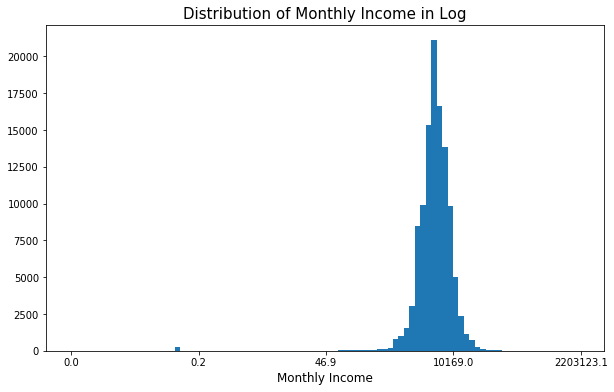

In [21]:
# log transform of montly income hist
log_hist(df,'StatedMonthlyIncome',0.1,'Monthly Income',-3)

In [22]:
# find out outliers of monthly income
extreme_income = ((df.StatedMonthlyIncome < 50) | (df.StatedMonthlyIncome > 100000))
print(df[extreme_income])

                     ListingKey     ListingCreationDate  Term  LoanStatus  \
78      0DFE3425061927556BB8A75 2008-06-29 23:23:40.157    36  Chargedoff   
100     0F67356860455769574096F 2013-01-25 11:48:26.040    36  Chargedoff   
108     10C034203841683992703F1 2008-04-29 08:26:00.340    36   Completed   
125     10EC3516168266498E5E38A 2011-05-10 12:53:38.783    36     Current   
146     34B03365511229087456DB5 2006-08-16 09:43:10.867    36   Completed   
...                         ...                     ...   ...         ...   
113686  FDD83406389901620745200 2007-12-04 18:18:14.747    36   Completed   
113761  E40A354460558377113BCF1 2012-04-18 11:49:35.887    60     Current   
113766  DE463545471486142487A42 2012-04-16 17:49:05.693    36     Current   
113767  DE48341184370727282B3F4 2008-01-22 07:15:09.207    36  Chargedoff   
113803  DEA93427782854712C73CB8 2008-08-01 01:42:00.820    36   Defaulted   

        BorrowerAPR  BorrowerRate  LenderYield  EstimatedReturn  ProsperSco

* After log transform of monthly income, it's generally normally distributed winthin the range of about 50-100k. We could also observe outliers on both low and high ends.
* The extreme stated monthly income data shows that most extreme values come from the low end, such as \\$0 income, while only a few come from the high end. The low end users are normally not employed or \\$0 in the income range

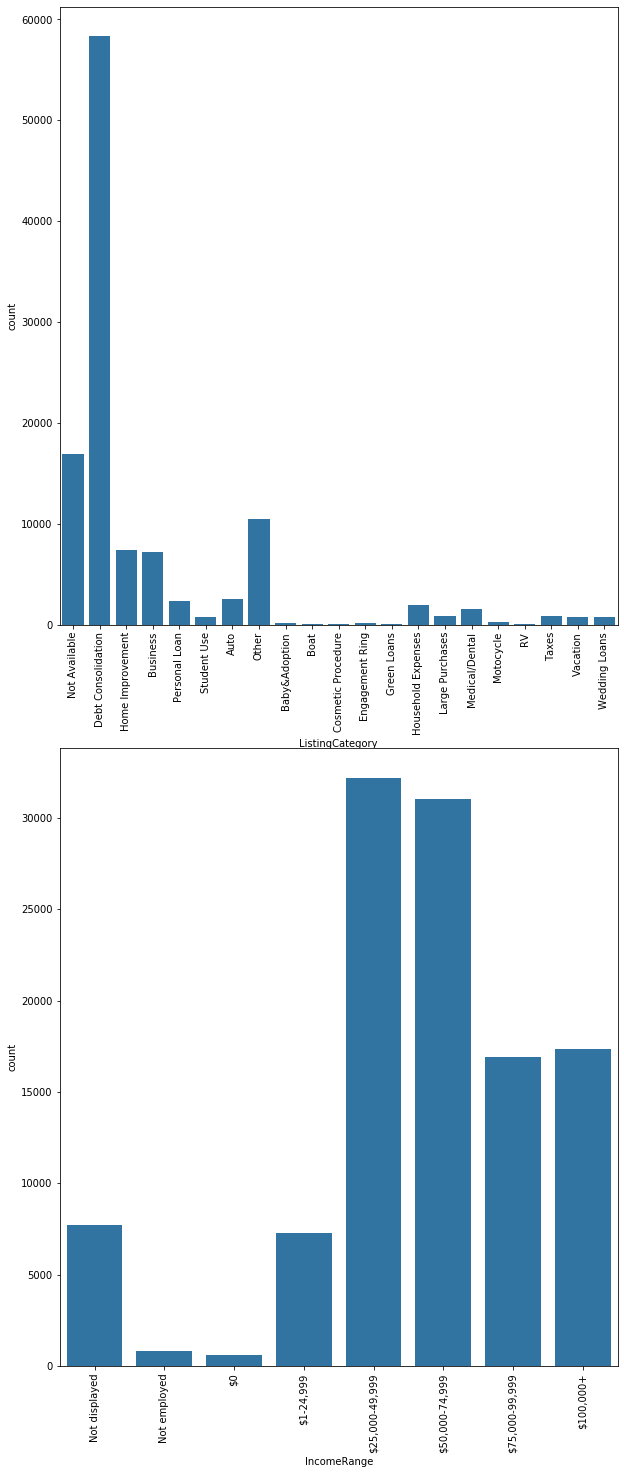

In [23]:
# plot category data: listing category and income range
fig,ax = plt.subplots(nrows=2,figsize=(10,25))
default_color = sb.color_palette()[0]
sb.countplot(data=df,x='ListingCategory',color=default_color,ax=ax[0])
sb.countplot(data=df,x='IncomeRange',color=default_color,ax=ax[1])
for i in fig.axes:
    plt.sca(i)
    plt.xticks(rotation=90);

* The most loan category is debt consolidation, and the most income range are $25000-74999.

In [24]:
# to delete the outliers from low credit, high debt, and monthly income distributions
df_clean = df[-low_credit & -high_debt & -extreme_income]
print(df_clean.info())
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111840 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ListingKey                  111840 non-null  object        
 1   ListingCreationDate         111840 non-null  datetime64[ns]
 2   Term                        111840 non-null  int64         
 3   LoanStatus                  111840 non-null  object        
 4   BorrowerAPR                 111815 non-null  float64       
 5   BorrowerRate                111840 non-null  float64       
 6   LenderYield                 111840 non-null  float64       
 7   EstimatedReturn             83979 non-null   float64       
 8   ProsperScore                83979 non-null   float64       
 9   ListingCategory             111840 non-null  category      
 10  CreditScoreRangeLower       111264 non-null  float64       
 11  CreditScoreRangeUpper       111264 non-

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedReturn,ProsperScore,CreditScoreRangeLower,CreditScoreRangeUpper,TotalCreditLinespast7years,AmountDelinquent,DebtToIncomeRatio,StatedMonthlyIncome,MonthlyLoanPayment,LP_NetPrincipalLoss
count,111840.000000,111815.000000,111840.000000,111840.000000,83979.000000,83979.000000,111264.000000,111264.000000,111225.000000,104528.000000,104771.000000,111840.000000,111840.000000,111840.000000
mean,40.897210,0.218326,0.192197,0.182137,0.095829,5.959014,686.402430,705.402430,26.851778,991.018961,0.243136,5656.280428,273.426211,660.453898
std,10.481266,0.080131,0.074610,0.074311,0.030336,2.378373,62.100363,62.100363,13.612101,7202.221547,0.148377,4075.953650,192.276985,2310.895879
min,12.000000,0.006530,0.000000,-0.010000,-0.182700,1.000000,420.000000,439.000000,2.000000,0.000000,0.000000,55.416667,0.000000,-954.550000
25%,36.000000,0.156290,0.133400,0.123400,0.074080,4.000000,660.000000,679.000000,17.000000,0.000000,0.140000,3333.333333,132.730000,0.000000
50%,36.000000,0.209310,0.182900,0.172500,0.091200,6.000000,680.000000,699.000000,25.000000,0.000000,0.220000,4750.000000,220.090000,0.000000
75%,36.000000,0.283240,0.250000,0.239900,0.115200,8.000000,720.000000,739.000000,35.000000,0.000000,0.310000,6865.729167,372.390000,0.000000
max,60.000000,0.512290,0.497500,0.492500,0.283700,11.000000,880.000000,899.000000,136.000000,463881.000000,1.990000,100000.000000,2251.510000,25000.000000


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

* The number of credit lines in the past 7 years has a right skewed disbtribution, so I did a log transform to see how it changes. After log transform, the distribution looks more like normal distribution.
* The debt to income ratio is also a little bit right-skewed with most values lower than 2 and outliers around 10 corresponding to someone with a large amount of debt. After a log transform, the distribution looks normal.
* After log transform of monthly income, it's generally normally distributed winthin the range of about 50-100k. We could also observe outliers on both low and high ends.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

* After filter out the low credit users, we could observe that most of them have weird other values, like not displayed for the income range, no prosper score, low credit upper score range, and high net principal loss.
* With over 2 debt to income ratio, the users most likely have low income and high total credit lines.
* The extreme stated monthly income data shows that most extreme values come from the low end, such as \\$0 income, while only a few come from the high end. The low end users are normally not employed or \\$0 in the income range.
* Since the outliers are only about 1% of the whole data, I deleted the outliers found in the above distributions.

## Bivariate Exploration

* I will start by exploring pairwise correlations between numeric data investigated in the previous sections

In [25]:
# define the numeric and categorical variables
numeric_var = ['LenderYield','BorrowerAPR','CreditScoreRangeLower','TotalCreditLinespast7years','DebtToIncomeRatio','StatedMonthlyIncome']
categoric_var = ['ListingCategory','IncomeRange']

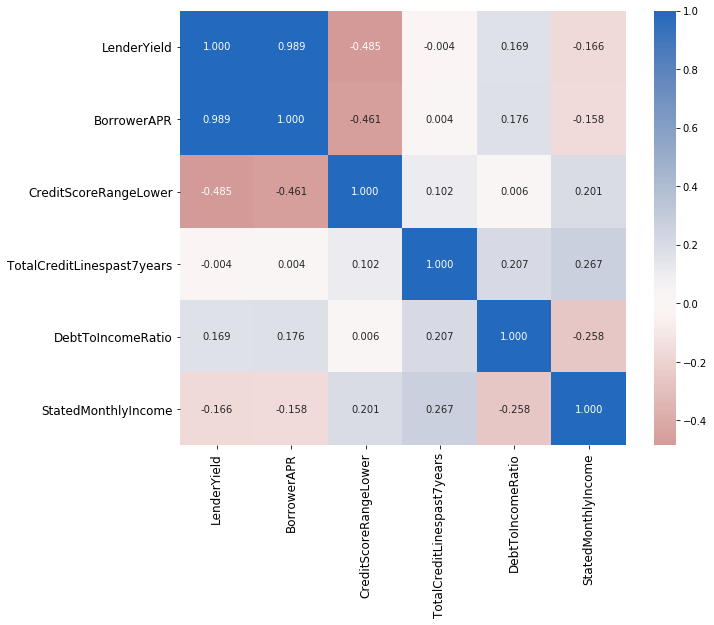

In [26]:
# plot the heatmap to explore correlation between numeric variables
plt.figure(figsize=(10,8))
sb.heatmap(df_clean[numeric_var].corr(),cmap='vlag_r',center=0,annot=True,fmt='.3f')
plt.xticks(size=12)
plt.yticks(size=12);

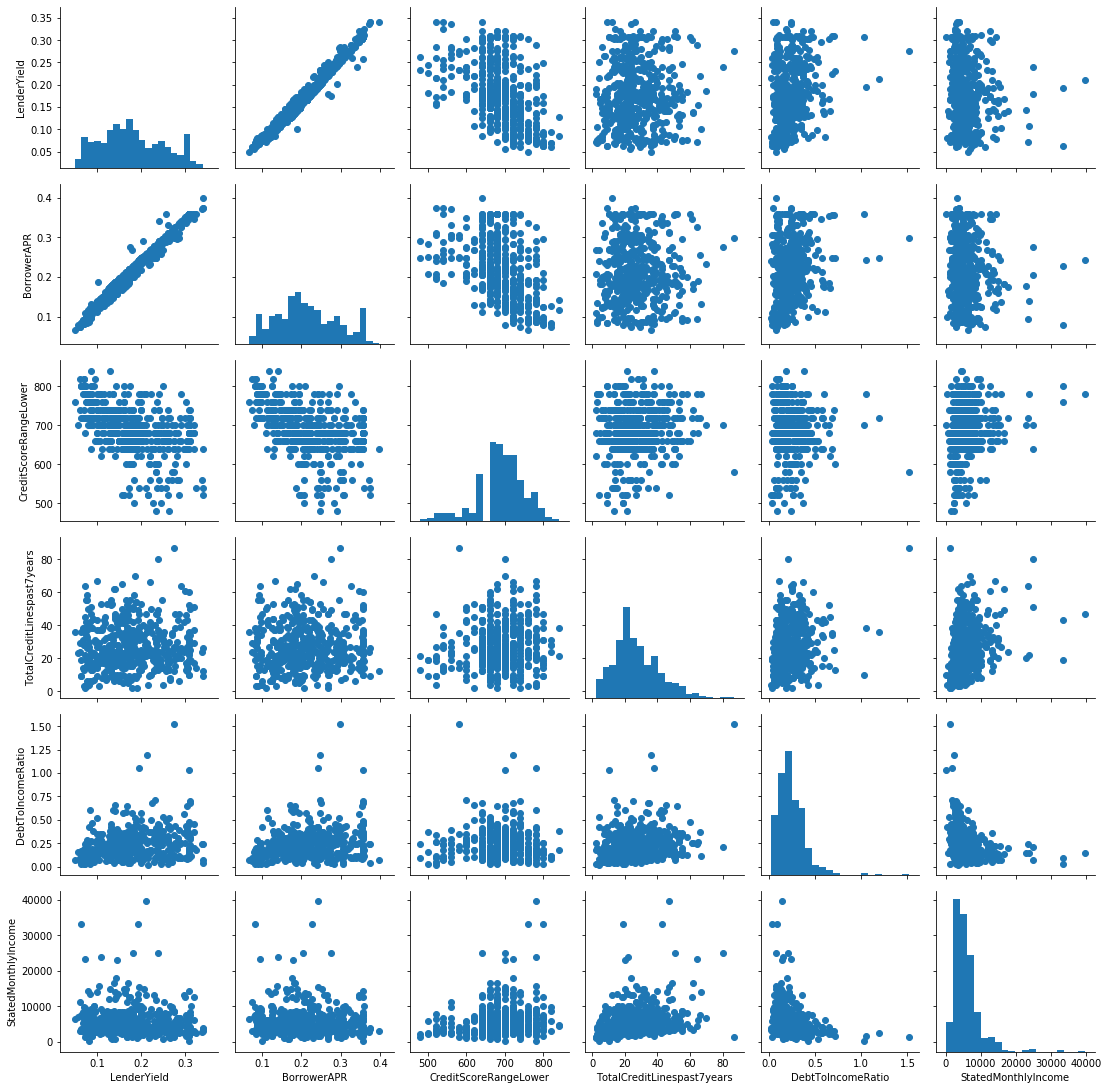

In [27]:
# plot scatter matrix of numeric variables
g = sb.PairGrid(data=df_clean.sample(500),vars=numeric_var)
g = g.map_offdiag(plt.scatter)
g.map_diag(plt.hist,bins=20);

* It can be seen that the lender's yield has a strong positive correlation with the borrower's apr.
* For the borrower's apr, it has a weak negative correlation with credit score, a very weak positive correlation with debt to income ratio, and maybe a very weak negative correlation with the monthly income.
* The relationship between borrower's apr and total credit line in the past 7 years looks very scatter and has almost 0 covariance. But that total credit lines is positively correlated with monthly income.


* Now let's see how the borrower's apr and lender's yield correlate with the categorical variables.

<Figure size 864x576 with 0 Axes>

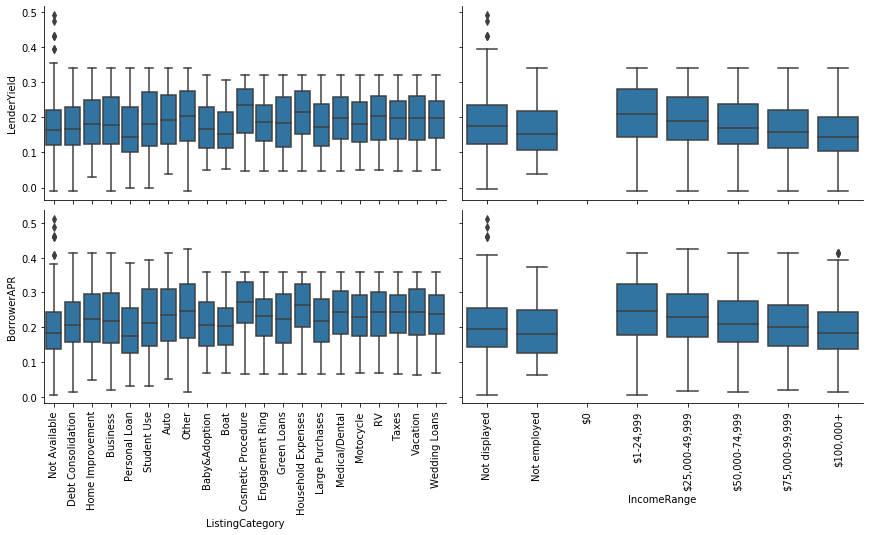

In [28]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)
    plt.xticks(size=10,rotation=90);

def box_matrix(df,numeric_var,categoric_var,h,ratio,func=boxgrid):
    '''
    seaborn PairGrid define the column and row numbers based on x_var and y_var
    height*aspect = width of each facet
    map boxgrid defined above to plot the box matrix
    '''
    plt.figure(figsize=(12,8))
    g = sb.PairGrid(data=df,x_vars=categoric_var,y_vars=numeric_var,aspect=ratio,height=h)
    g.map(func);
box_matrix(df_clean,['LenderYield','BorrowerAPR'],categoric_var,3,2)

* It should be noticed that there seems to be a negative correlation between borrower's apr/lender's yield and the income range, while no obvious relationship observed for the listing category.
* The highest borrower's apr/lender's yield are from cosmetic procedure and household exponses customers, and the lowest one is from personal loan.


* Now let's look at the relationship between the two categorical variables.

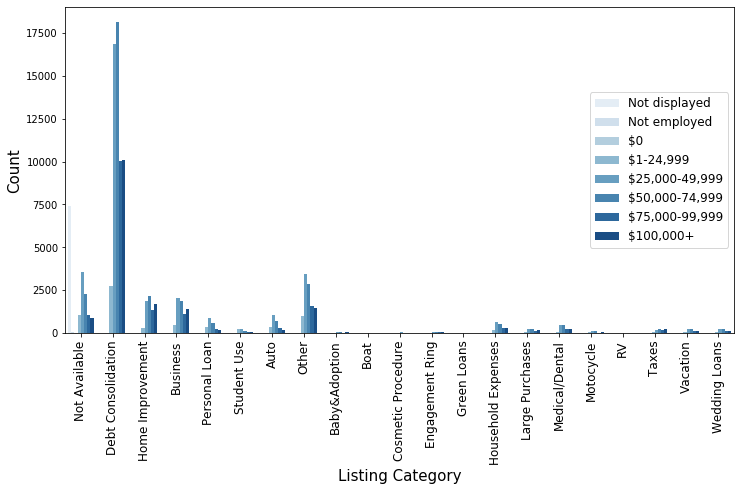

In [29]:
# count of listing category vs income range
fig,ax = plt.subplots(figsize=(12,6))
sb.countplot(data=df_clean,x='ListingCategory',hue='IncomeRange',palette='Blues',ax=ax)
new_value = 0.1
for patch in ax.patches:
    current_width = patch.get_width()
    # change the bar width
    patch.set_width(new_value)
    diff = current_width - new_value
    # recenter the bar
    patch.set_x(patch.get_x() + diff * 0.5)
plt.xticks(rotation=90,size=12)
plt.legend(loc='right',fontsize=12)
plt.xlabel('Listing Category',size=15)
plt.ylabel('Count',size=15);

* The observations here are consistent with those in previous figures. The listing category with most customers is debt consolidation with the income range of 25000-99999.


* With the preliminary look at bivariate relationship out of the way, I also want to explore the relationship between borrower's apr and log transformed debt to income ratio and monthly income.

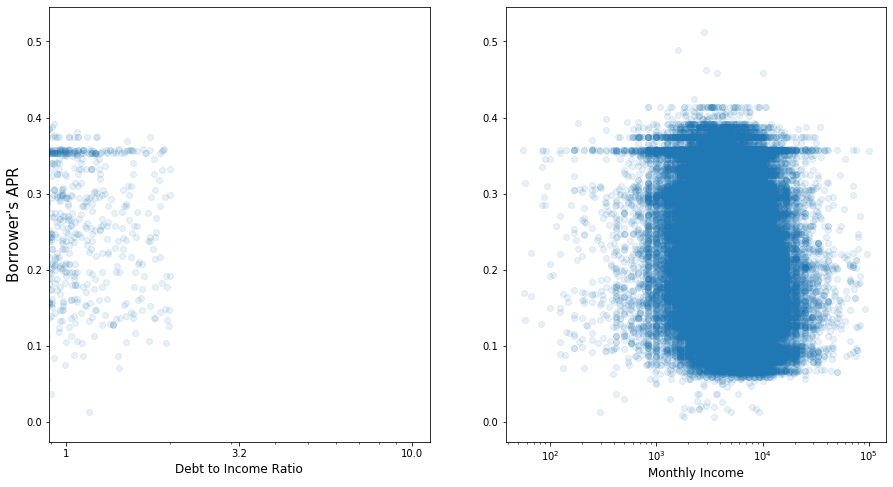

In [59]:
# scatter plot of borrower's apr vs. credit score at low range with log transformed on x axis
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,8))
ax[0].scatter(data=df_clean,x='DebtToIncomeRatio',y='BorrowerAPR',alpha=0.1)
ax[0].set_xscale('log')
ax[0].set_xlabel('Debt to Income Ratio',size=12)
ax[0].set_xticks([1,10**0.5,1e1])
ax[0].set_xticklabels([1,round(10**0.5,1),1e1])
ax[0].set_ylabel("Borrower's APR",size=15)
ax[1].scatter(data=df_clean,x='StatedMonthlyIncome',y='BorrowerAPR',alpha=0.1)
ax[1].set_xscale('log')
ax[1].set_xlabel('Monthly Income',size=12);

* It can be seen that no obvious relationship is observed between borrow's apr and the debt to income ratio or monthly income.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* It can be seen that the lender's yield has a strong positive correlation with the borrower's apr.
* For the borrower's apr, it has a weak negative correlation with credit score, a very weak positive correlation with debt to income ratio, and maybe a very weak negative correlation with the monthly income.
* The relationship between borrower's apr and total credit line in the past 7 years looks very scatter and has almost 0 covariance. But that total credit lines is positively correlated with monthly income.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

* It should be noticed that there seems to be a negative correlation between borrower's apr/lender's yield and the income range, while no obvious relationship observed for the listing category.
* The highest borrower's apr/lender's yield are from cosmetic procedure and household exponses customers, and the lowest one is from personal loan.
* The observations here are consistent with those in previous figures. The listing category with most customers is debt consolidation with the income range of 25000-99999.

## Multivariate Exploration

* In this part, I want to explore how the two categorical variables play a role in the relationship between lender's yield and borrower's apr

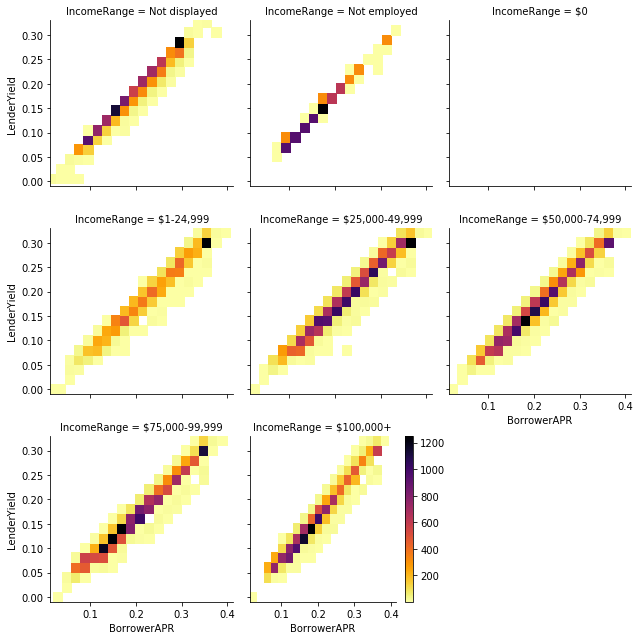

In [68]:
def hist2dgrid(x,y,**kwargs):
    palette = kwargs.pop('color')
    x_step = kwargs.pop('x_step')
    y_step = kwargs.pop('y_step')
    x_bins = np.arange(x.min(),x.max(),x_step)
    y_bins = np.arange(y.min(),y.max(),y_step)
    plt.hist2d(x,y,bins=[x_bins,y_bins],cmap=palette,cmin=0.5)
g = sb.FacetGrid(data=df_clean,col='IncomeRange',col_wrap=3,height=3)
g.map(hist2dgrid,'BorrowerAPR','LenderYield',x_step=0.02,y_step=0.02,color='inferno_r')
plt.colorbar();

* For the low income clients the apr concentrates in the high end, while the medium income borrowers spread out the whole range of apr, and the highest income customers have relatively lowest apr range as well as lender's yield.


* Let's look at the situation for the listing category.

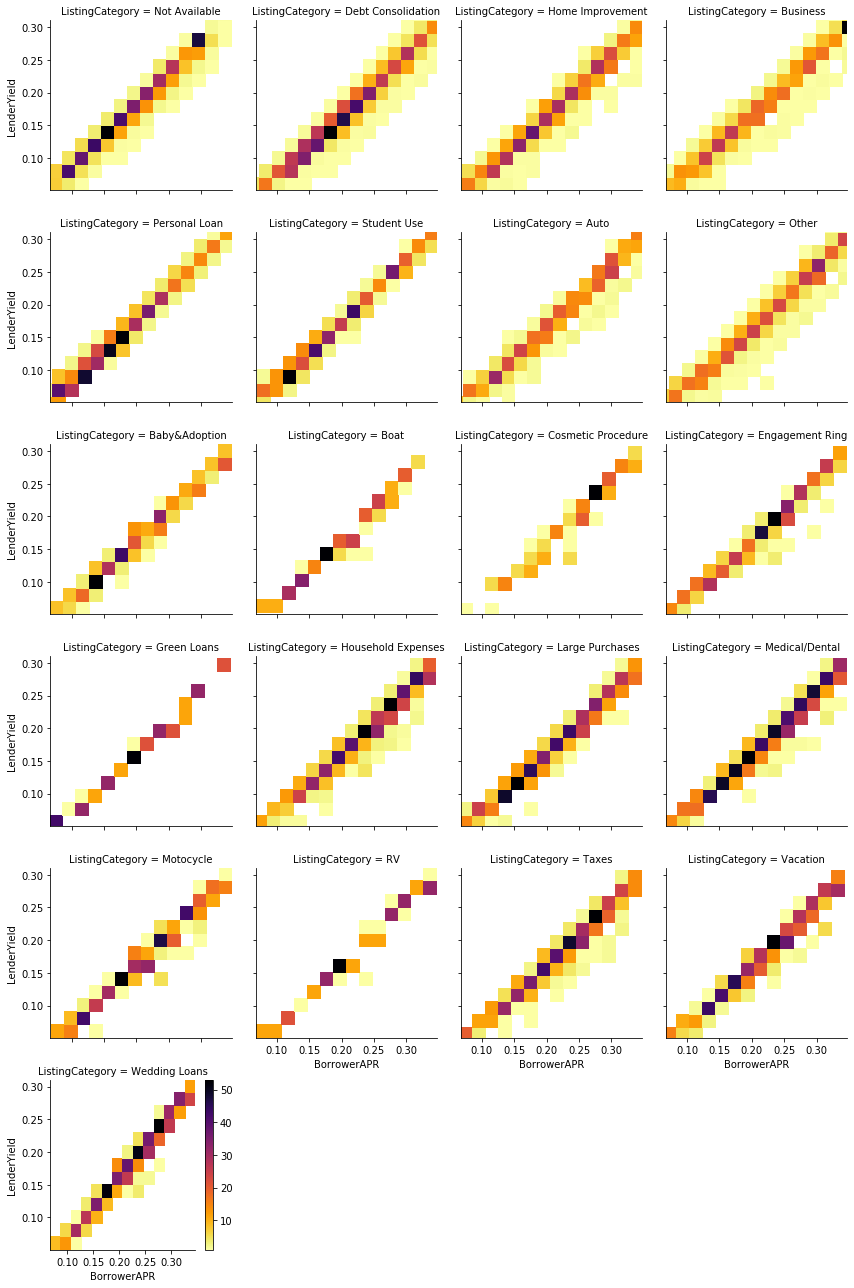

In [69]:
g = sb.FacetGrid(data=df_clean,col='ListingCategory',col_wrap=4,height=3)
g.map(hist2dgrid,'BorrowerAPR','LenderYield',x_step=0.02,y_step=0.02,color='inferno_r')
plt.colorbar();

* According to the previous section, the highest yield comes from cosmetic procedure and household expenses that agree with the distributions here. And the personal loan is the lowest which can be evidenced through the distribution here mainly found in the low apr range.


* To further explore the impact of the categorical data, let's take a look at the lender's yield vers listing category in point plot with two major apr ranges, 0.25-0.30 and 0.15-0.20

In [71]:
# mask two ranges of apr, low: 0.15-0.20 and high: 0.25-0.30
df_high = df_clean.query('BorrowerAPR>=0.25 & BorrowerAPR<=0.30')
df_low = df_clean.query('BorrowerAPR>=0.15 & BorrowerAPR<=0.20')

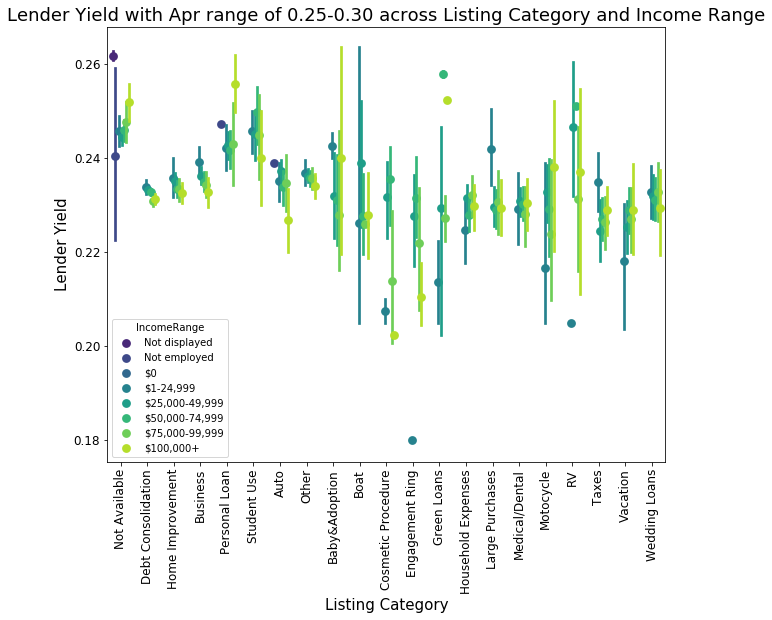

In [88]:
plt.figure(figsize=(10,8))
sb.pointplot(data=df_high,x='ListingCategory',y='LenderYield',hue='IncomeRange',
           join=False,dodge=0.6,palette='viridis')
plt.title('Lender Yield with Apr range of 0.25-0.30 across Listing Category and Income Range',size=18)
plt.xlabel('Listing Category',size=15)
plt.xticks(rotation=90,size=12)
plt.ylabel('Lender Yield',size=15)
plt.yticks(size=12);

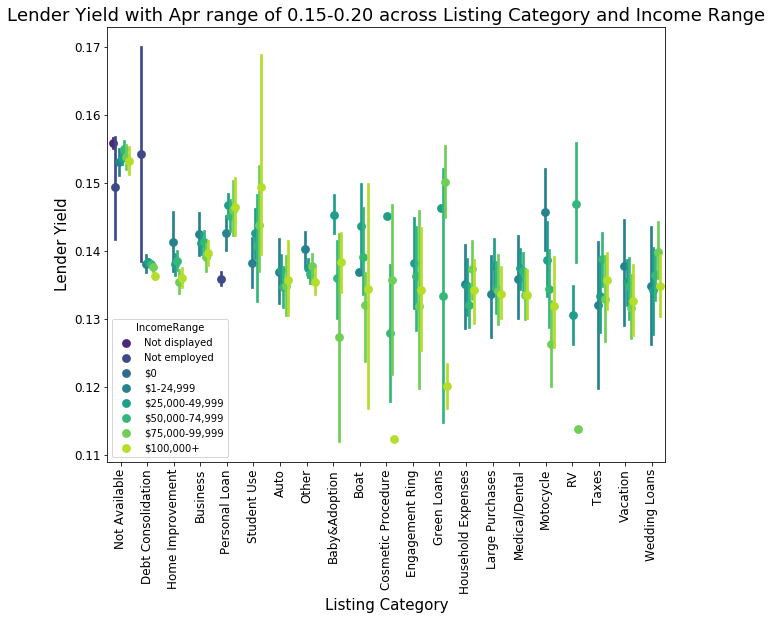

In [89]:
plt.figure(figsize=(10,8))
sb.pointplot(data=df_low,x='ListingCategory',y='LenderYield',hue='IncomeRange',
           join=False,dodge=0.6,palette='viridis')
plt.title('Lender Yield with Apr range of 0.15-0.20 across Listing Category and Income Range',size=18)
plt.xlabel('Listing Category',size=15)
plt.xticks(rotation=90,size=12)
plt.ylabel('Lender Yield',size=15)
plt.yticks(size=12);

* From the two figures, it can be observed that for lower range of lender's yield the high income customers have higher variance, while for higher range of lender's yield the situation is the opposite - the low income borrowers have higher variance. 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

* For the low income clients the apr concentrates in the high end, while the medium income borrowers spread out the whole range of apr, and the highest income customers have relatively lowest apr range as well as lender's yield.
* According to the previous section, the highest yield comes from cosmetic procedure and household expenses that agree with the distributions here. And the personal loan is the lowest which can be evidenced through the distribution here mainly found in the low apr range. 

### Were there any interesting or surprising interactions between features?

* From the two figures, it can be observed that for lower range of lender's yield the high income customers have higher variance, while for higher range of lender's yield the situation is the opposite - the low income borrowers have higher variance.